In [1]:
import sys
import os
#import random forrest from sklearn 
from sklearn.ensemble import RandomForestClassifier


sys.path.append(os.path.abspath('../../src'))

# add functions explicitly to the path
from utils import *
from data_cleaning import *
from pipeline import *

from sklearn.metrics import f1_score

In [2]:
df_X, df_y = load_data_train()

In [3]:
df_y['damage_grade'].isna().sum()

np.int64(0)

In [4]:
df_X = convert_to_object(df_X)
df_X['geo_level_1_id'] = df_X['geo_level_1_id'].astype('object')
df_X['geo_level_2_id'] = df_X['geo_level_2_id'].astype('object')
df_X['geo_level_3_id'] = df_X['geo_level_3_id'].astype('object')

In [5]:
df_X, df_y = drop_duplicates(df_X,df_y)

In [6]:
outliers_ids = get_outliers_ids(df_X)

tot number of outliers: 10526
- count_floors_pre_eq - number of outliers: 2439
- age - number of outliers: 1259
- area_percentage - number of outliers: 3811
- height_percentage - number of outliers: 2407
- count_families - number of outliers: 2325


In [7]:
df_X, df_y = drop_row(outliers_ids.tolist(), df_X, df_y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42, stratify=df_y['damage_grade'])
X_train, y_train =  resample_data(X_train, y_train, 'both')


y_train, y_test = y_train.drop(['building_id'], axis=1), y_test.drop(['building_id'], axis=1)
X_train, X_test = X_train.drop(['building_id'], axis=1), X_test.drop(['building_id'], axis=1)
numerical_feature = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_feature = X_train.select_dtypes(include=['object']).columns.tolist()


standard_scaler_cols = numerical_feature
robust_scaler_cols = []
baseN_enc_cols = categorical_feature
ordinal_enc_cols = []
one_hot_cols = []

Before resampling - Class 1 size: 17451, Class 2 size: 62539, Class 3 size: 107117


ValueError: Cannot sample 75046 out of arrays with dim 62539 when replace is False

In [52]:
X_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,11,147,9813,3,15,9,8,t,i,x,...,0,0,0,1,0,0,0,0,0,0
1,10,151,7723,3,5,20,9,t,i,x,...,0,0,1,0,0,0,0,0,0,0
2,20,1402,9001,2,45,4,3,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,13,1154,5051,2,45,8,5,n,r,n,...,0,0,0,0,0,0,0,0,0,0
4,13,257,8318,2,5,5,3,t,r,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187612,17,1149,5220,3,15,7,7,t,r,n,...,0,0,0,0,0,0,0,0,0,0
187613,6,1060,183,2,20,9,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
187614,17,1149,5220,3,0,10,7,t,r,n,...,0,0,0,0,0,0,0,0,0,0
187615,3,1006,5957,2,20,5,5,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [53]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

pre_proccessor = pipeline_preprocessor(standard_scaler_cols=standard_scaler_cols,baseN_enc_cols=baseN_enc_cols)
pipeline = classifier_pipeline(pre_proccessor, model)

In [54]:
model_fit = model_training(X_train,y_train,pipeline)

/Users/davide/miniconda3/envs/DA_env/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [55]:
model_fit

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['count_floors_pre_eq', 'age',
                                                   'area_percentage',
                                                   'height_percentage',
                                                   'count_families']),
                                                 ('robust_scaler',
                                                  RobustScaler(), []),
                                                 ('baseN_encoder',
                                                  BaseNEncoder(cols=['geo_level_1_id',
                                                                     'geo_level_2_id',
                                                                     'geo_level_3_id',
                                                                     'land_surface_condition',
                                                                     'foundation_typ...
                                                   'legal_ownership_status',
                                                   'has_secondary_use',
                                                   'has_secondary_use_agriculture',
                                                   'has_secondary_use_hotel',
                                                   'has_secondary_use_rental',
                                                   'has_secondary_use_institution',
                                                   'has_secondary_use_school',
                                                   'has_secondary_use_industry',
                                                   'has_secondary_use_health_post', ...]),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(), [])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [56]:
y_pred = model_fit.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print(score)

0.6985484319216709


In [169]:
# no upsample: 0.7275584154605896  # upsample: 0.7281997562904846

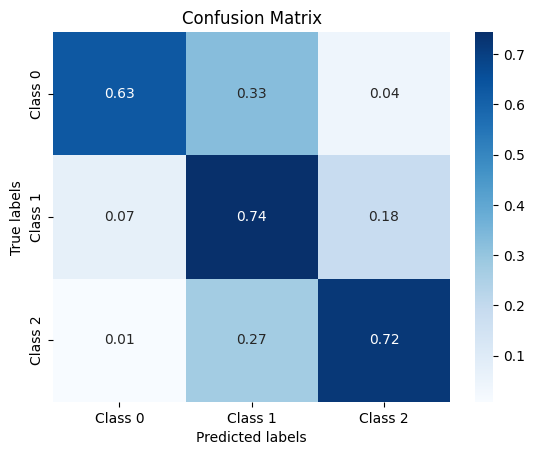

In [13]:
# nothing
print_confusion_matrix(y_test, y_pred)

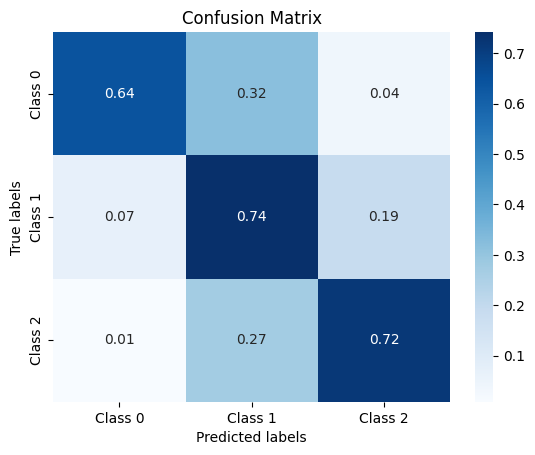

In [29]:
print_confusion_matrix(y_test, y_pred)

In [92]:
# test the model
df_test = load_data_test()
df_test = convert_to_object(df_test)
df_test_id = df_test.pop('building_id')

In [93]:
test_predictions = model_fit.predict(df_test)
df_submission = pd.DataFrame({'building_id': df_test_id, 'damage_grade': test_predictions})

In [20]:
df_submission

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,2
86865,1049160,2
86866,442785,2


In [94]:
df_submission.to_csv('../../results/20250130_10_48_submission.csv', index=False)